# Machine learning in economics

**Prerequisites**

- applications/regression  


**Outcomes**

- Understand the ways that economists are using machine learning in
  academic research  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline
#plt.style.use('tableau-colorblind10')
#plt.style.use('Solarize_Light2')
plt.style.use('bmh')

## Introduction

Machine learning is increasingly being utilized in economic
research. Here, we discuss three main ways that economists are
currently using machine learning methods.

## Prediction Policy

The most obvious situation where machine learning methods can be used
in economic research or policy making is when the goal is prediction
per se. Most empirical economic research focuses on questions of
causuality. However, there are interesting economic situations and
policy questions where the goal is prediction instead of causality.
[[KLMO15]](#kleinberg2015) is a short paper making this point.

> Consider two toy examples. One policymaker facing a drought must
decide whether to invest in a rain dance to increase the chance
of rain.  Another seeing clouds must decide whether to take an
umbrella to work to avoid getting wet on the way home. Both
decisions could benefit from an empirical study of rain. But each
has differ-ent requirements of the estimator. One requires
causality: Do rain dances cause rain? The other does not, needing
only prediction: Is the chance of rain high enough to merit an
umbrella?  We often focus on rain dance–like policy problems. But
there are also many umbrella-like policy problems.  Not only are
these prediction problems neglected, machine learning can help
us solve them more effectively.  [[KLMO15]](#kleinberg2015)


An example that they give is the allocation of joint replacements for
osteoarthritis in elderly patients. Joint replacements are costly,
both monetarily and in terms of potentially painful recovery from
surgery. Joint replacements may not be worthwhile for patients who do
not live long enough afterward to enjoy the
benefits. [[KLMO15]](#kleinberg2015) use machine learning methods to
predict mortality, and argue that not performing joint replacements
for people with the highest predicted mortality risk could lead to
sizeable benefits.

Other situations where improved prediction could improve economic
policy include:

- Targeting safety or health inspections  
- Predicting highest risk youth for targeting interventions  
- Improved risk scoring in insurance markets to reduce adverse
  selection  
- Improved credit scoring to better allocate credit  
- Predicting the risk someone accused of a crime does not show up for
  trial to help decide whether to offer bail [[KMR17]](#kleinberg2017)  


We investigated one such prediction policy problem in
applications/recidivism .

## Estimation of Nuisance Functions

Most empirical economic studies are interested in a single low
dimensional parameter, but to estimate this parameter, many additional
“nuisance” parameters might have to be estimated. In most regression
models, there is one explanatory variable of interest, and the
researcher’s main goal is to estimate the coefficient on this
variable. To estimate this coefficient consistently, often many other
variables are included in the regression to avoid omitted variables
bias. However, the choice of which other variables to include and
their functional forms is often somewhat arbitrary.
One promising idea is to use machine learning methods to let the data
decide what control variables to include and how. Care must be
taken when doing so though because the flexibility and complexity
that make machine learning so good at prediction also pose
challenges for inference.

### Partially Linear Regression

To be more concrete, consider a regression model.  We have some
regressor of interest, $ d $, and we want to estimate the effect of $ d $
on $ y $. We have a rich enough set of controls, $ x $ that we are willing to
believe that $ E[\epsilon|d,x] = 0 $ . $ d_i $ and $ y_i $ are scalars, while
$ x_i $ is a vector. We are not interested in $ x $ per se, but we need to
include it to avoid omitted variable bias. Suppose the true model
generating the data is

$$
y = \theta d + f(x) + \epsilon
$$

where $ f(x) $ is some unknown function. This is called a
partially linear model it is linear in $ d $, but not in
$ x $ .

A typical applied econometric approach for this model would
be to choose some transfrom of $ x $, say $ X = T(x) $, where $ X $
could be some subset of $ x $ , perhaps along with interactions, powers, and
so on. Then estimate a linear regression

$$
y = \theta d + X'\beta + e
$$

and then perhaps also report results for a handful of different
choices of $ T(x) $ .

Some downsides to the typical applied econometric practice
include:

- The choice of T is arbitrary, which opens the door to specification
  searching and p-hacking.  
- If $ x $ is high dimensional, and $ X $ is low dimensional, a poor
  choice will lead to omitted variable bias. Even if $ x $ is low
  dimensional, if $ f(x) $ is poorly approximated by $ X'\beta $
  , there will be omitted variable bias.  


In some sense, machine learning can be thought of as a way to
choose $ T $ is an automated and data-driven way. There will be
still be a choice of machine learning method and often tuning
parameters for that method, so some arbitrary decisions
remain. Hopefully though these decisions have less impact.

Economic researchers typically want not just an estimate of
$ \theta $, $ \hat{\theta} $, they also want to know that
$ \hat{\theta} $ has good statistical properties (it should at
least be consistent), and they want some way to quantify how uncertain is
$ \hat{\theta} $ (i.e. they want a standard error). The complexity
of machine learning methods makes their statistical properties
difficult to understand. If we want $ \hat{\theta} $ to have
known and good statistical properties we must make sure we use machine
learning methods in the correct way.  A procedure to estimate
$ \theta $ in the partially linear model is as follows:

1. Predict $ y $ and $ d $ from $ x $ using any machine
  learning method with “cross-fitting”  
  - Partition the data in $ k $ subsets  
  - For the $ j $ th subset, train models to predict $ y $ and $ d $
    using the other $ k-1 $ subsets. Denote the predictions from
    these models as $ p^y_{-j}(x) $ and  $ p^d_{-j}(x) $  
  - For $ y_i $ in the $ j $ -th subset use the other
    $ k-1 $ subsets to predict $ \hat{y}_i = p^y_{-j(i)}(x_i) $  
1. Partial out $ x $ : let $ \tilde{y}_i = y_i - \hat{y}_i $
  and $ \tilde{d}_i = d_i - \hat{d}_i $  
1. Regress $ \tilde{y}_i $ on $ \tilde{d}_i $, let
  $ \hat{\theta} $ be the estimated coefficient for
  $ \tilde{d}_i $ . $ \hat{\theta} $ is consistent,
  asymptotically normal, and has the usual standard error (i.e. the
  standard error given by statsmodels is correct)  


Some remarks

- This procedure gives a $ \hat{\theta} $ that has the same
  asymptotic distribution as what we would get if we knew the true
  $ f(x) $ . In statistics we call this an oracle property,
  because it is as if an all knowing oracle told us $ f(x) $  
- There are some technical conditions on the data generating
  process and machine learning estimator needed for this procedure to
  work. We will not worry about them here. See
  [[CCD+18]](#chernozhukov2018) for details.  


Here is code implementing the above idea.

In [2]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import statsmodels as sm

def partial_linear(y, d, X, yestimator, destimator, folds=3):
    """Estimate the partially linear model y = d*C + f(x) + e

    Parameters
    ----------
    y : array_like
        vector of outcomes
    d : array_like
        vector or matrix of regressors of interest
    X : array_like
        matrix of controls
    mlestimate : Estimator object for partialling out X. Must have ‘fit’
        and ‘predict’ methods.
    folds : int
        Number of folds for cross-fitting

    Returns
    -------
    ols : statsmodels regression results containing estimate of coefficient on d.
    yhat : cross-fitted predictions of y
    dhat : cross-fitted predictions of d
    """

    # we want predicted probabilities if y or d is discrete
    ymethod = "predict" if False==getattr(yestimator, "predict_proba",False) else "predict_proba"
    dmethod = "predict" if False==getattr(destimator, "predict_proba",False) else "predict_proba"
    # get the predictions
    yhat = cross_val_predict(yestimator,X,y,cv=folds,method=ymethod)
    dhat = cross_val_predict(destimator,X,d,cv=folds,method=dmethod)
    ey = np.array(y - yhat)
    ed = np.array(d - dhat)
    ols = sm.regression.linear_model.OLS(ey,ed).fit(cov_type='HC0')

    return(ols, yhat, dhat)

### Application: Gender Wage Gap

Okay, enough theory, let’s look at an application. Policy makers have
long been concerned with the gender wage gap. We will examine the
gender wage gap using data from the 2018 Current Population Survey (CPS) in
the US. In particular, we will use the version of the [CPS provided by
the NBER.](https://www.nber.org/cps/)

In [3]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
# Download CPS data
cpsall = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")

# take subset of data just to reduct computation time
# FIXME: set rng seed to make reproducible
cps = cpsall.sample(30000, replace=False)
display(cps.head())
cps.describe()

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
138383,128262060129437,June,1.0,Unmarried civilian female primary fam householder,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,701,698,0,0,0,0,0,12.0,NaN,NaN
20917,402900112042693,January,1.0,Civilian female primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,696,693,0,0,0,0,0,12.0,Sales and related occupations,Retail trade
186673,612890150305303,August,2.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,703,700,0,0,0,0,0,7.5,NaN,NaN
200407,135887140805502,August,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,703,700,1,0,0,0,1,NaN,NaN,NaN
2935,016922715042630,January,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0601,06011,1,1,...,696,681,1,0,0,0,1,NaN,NaN,NaN


,hurespli,hhnum,cbsafips,county,centcity,smsastat,icntcity,smsa04,relref95,age,...,recnum,year,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc
count,29998.000000,30000.000000,30000.000000,30000.000000,24698.000000,29705.000000,3749.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.0,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,21457.000000
mean,1.321588,1.053767,22596.557667,25.278300,1.935744,1.192224,1.377967,3.666967,3.150267,47.958733,...,217089.875000,2018.0,701.470200,692.387800,0.061233,0.067133,0.138867,0.084400,0.106400,12.405159
std,0.699240,0.244699,16551.506485,60.776606,0.722865,0.394054,0.945616,2.606162,3.214721,18.714967,...,125608.234375,0.0,3.464964,6.956974,0.239762,0.250257,0.345813,0.277991,0.308354,2.429141
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.000000,...,2.000000,2018.0,696.000000,681.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,...,108696.500000,2018.0,698.000000,686.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,1.000000,1.000000,24860.000000,0.000000,2.000000,1.000000,1.000000,4.000000,2.000000,48.000000,...,216515.000000,2018.0,701.000000,692.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,1.000000,1.000000,37100.000000,27.000000,2.000000,1.000000,1.000000,6.000000,3.000000,63.000000,...,325786.500000,2018.0,704.000000,698.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,11.000000,8.000000,49740.000000,810.000000,3.000000,2.000000,7.000000,7.000000,18.000000,85.000000,...,434289.000000,2018.0,707.000000,704.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000


The variable “earnwke” records weekly earnings. There are two
variables about hours of work. “uhours” is usual hours worked per
week, and “hourslw” is hours worked last week. We will try using each
measure of hours to construct the wage.  Let’s estimate the
unconditional gender earnings and wage gaps.

In [4]:
cps["female"] = (cps.sex==2)
cps["log_earn"] = np.log(cps.earnwke)
cps["log_earn"][np.isinf(cps.log_earn)] = np.nan
cps["log_uhours"] = np.log(cps.uhourse)
cps["log_uhours"][np.isinf(cps.log_uhours)] = np.nan
cps["log_hourslw"] = np.log(cps.hourslw)
cps["log_hourslw"][np.isinf(cps.log_hourslw)] = np.nan
cps["log_wageu"] = cps.log_earn - cps.log_uhours
cps["log_wagelw"] = cps.log_earn - cps.log_hourslw


lm = list()
lm.append(smf.ols(formula="log_earn ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append( smf.ols(formula="log_wageu ~ female", data=cps,
                   missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_wagelw ~ female", data=cps,
                  missing="drop").fit(cov_type='HC0'))
lm.append(smf.ols(formula="log_earn ~ female + log_hourslw + log_uhours", data=cps,
                  missing="drop").fit(cov_type='HC0'))

summary_col(lm, stars=True)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be se

,log_earn I,log_wageu I,log_wagelw I,log_earn II
Intercept,6.7646***,3.1072***,3.1097***,1.8994***
,(0.0090),(0.0075),(0.0080),(0.0807)
female[T.True],-0.3282***,-0.1883***,-0.1764***,-0.1452***
,(0.0131),(0.0107),(0.0116),(0.0107)
log_hourslw,,,,0.0529**
,,,,(0.0238)
log_uhours,,,,1.2762***
,,,,(0.0356)


#### Equal Pay for Equal Work?

A common slogan is equal pay for equal work. One way to interpret this
is conditional on observable job and work characteristics, there
should be no gender wage gap.

Lack of a gender wage gap conditional on observables is a necessary
but not sufficient condition for equality. Some of the differences
in observables (like hours in the 4th column of the above table)
might themselves be a result of societal norms and/or
discrimination, and we may not want to hold them constant.

Nonetheless, let’s examine whether there is a gender wage gap
conditional on all worker and job characteristics. We want to ensure
that we control for worker and job characteristics as flexibly as
possible, so we will use the partially linear model described above.

In [5]:
from patsy import dmatrices
# Prepare data
fmla  = "log_earn + female ~ log_uhours + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)"
yd, X = dmatrices(fmla,cps)
female = yd[:,1]
logearn = yd[:,2]

In [6]:
# select regularization parameter
alphas = np.exp(np.linspace(-2, -12, 25))
lassoy = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,logearn)
lassod = linear_model.LassoCV(cv=6, alphas=alphas, max_iter=5000).fit(X,female)

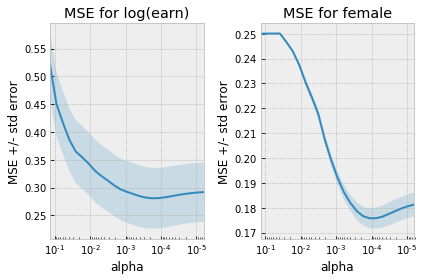

In [7]:
fig, ax = plt.subplots(1,2)

def plotlassocv(l, ax) :
    alphas = l.alphas_
    mse = l.mse_path_.mean(axis=1)
    std_error = l.mse_path_.std(axis=1)
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse + std_error, mse - std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotlassocv(lassoy,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotlassocv(lassod,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MAYBE WRONG
def pickalpha(lassocv) :
    imin = np.argmin(lassocv.mse_path_.mean(axis=1))
    msemin = lassocv.mse_path_.mean(axis=1)[imin]
    se = lassocv.mse_path_.std(axis=1)[imin]
    alpha= min([alpha for (alpha, mse) in zip(lassocv.alphas_, lassocv.mse_path_.mean(axis=1)) if mse<msemin+se])
    return(alpha)

alphay = pickalpha(lassoy)
alphad = pickalpha(lassod)

In [8]:
# show results
pl_lasso = partial_linear(logearn, female, X,
                          linear_model.Lasso(alpha=lassoy.alpha_),
                          linear_model.Lasso(alpha=lassod.alpha_))
pl_lasso[0].summary()

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     117.2
Date:                Thu, 28 Mar 2019   Prob (F-statistic):           3.43e-27
Time:                        12:15:43   Log-Likelihood:                -10117.
No. Observations:               12954   AIC:                         2.024e+04
Df Residuals:                   12953   BIC:                         2.024e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1239      0.011    -10.825      0.000      -0.146      -0.101
==============================================================================
Omnibus:                    11290.624   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2102409.543
Skew:                          -3.498   Prob(JB):                         0.00
Kurtosis:                      65.018   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

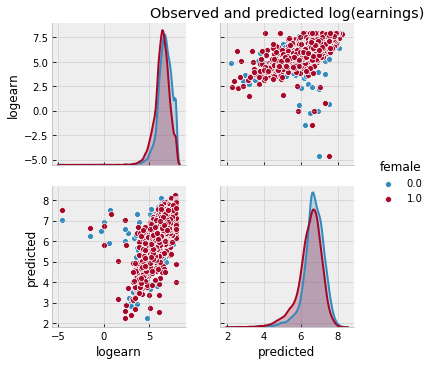

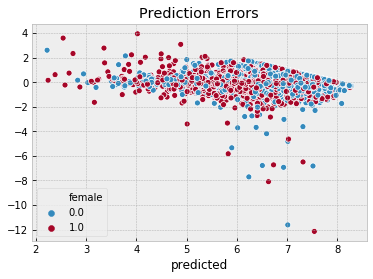

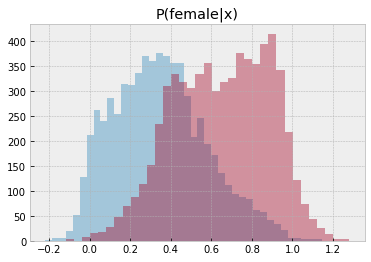

In [9]:
import seaborn as sns
# Visualize predictions
def plotpredictions(pl) :
    df = pd.DataFrame({"logearn":logearn,
                       "predicted":pl[1],
                       "female":female,
                       "P(female|x)":pl[2]})
    sns.pairplot(df, vars=["logearn","predicted"], hue="female")
    plt.title("Observed and predicted log(earnings)")

    plt.figure()
    sns.scatterplot(df.predicted, df.logearn-df.predicted, hue=df.female)
    plt.title("Prediction Errors")

    plt.figure()
    sns.distplot(pl[2][female==0], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Male")
    sns.distplot(pl[2][female==1], hist = True, kde = False,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 label = "Female")
    plt.title('P(female|x)')
plotpredictions(pl_lasso)

In [10]:
from sklearn import neural_network
from sklearn import preprocessing, pipeline, model_selection

nnp = pipeline.Pipeline(steps=[
    ("scaling", preprocessing.StandardScaler()),
    ("nn", neural_network.MLPRegressor((50,), activation="logistic",
                                       verbose=False, solver="adam",
                                       max_iter=400, early_stopping=True,
                                       validation_fraction=0.15))
])

nndcv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     iid=True).fit(X,female)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.7min finished


In [11]:
nnycv = model_selection.GridSearchCV(estimator=nnp, scoring= 'neg_mean_squared_error', cv=4,
                                     param_grid = {'nn__alpha': np.exp(np.linspace(-5,5, 10))},
                                     return_train_score=True, verbose=True, refit=False,
                                     iid=True).fit(X,logearn)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.5min finished


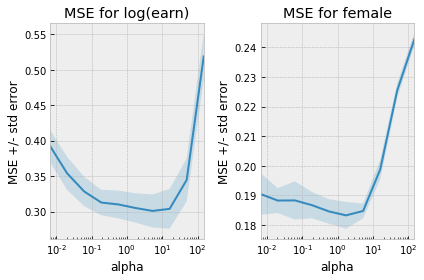

In [12]:
fig, ax = plt.subplots(1,2)

def plotgridcv(g, ax) :
    alphas = g.cv_results_["param_nn__alpha"].data.astype(float)
    mse = -g.cv_results_["mean_test_score"]
    std_error = g.cv_results_["std_test_score"]
    ax.plot(alphas,mse)
    ax.fill_between(alphas, mse+std_error, mse-std_error, alpha=0.2)

    ax.set_ylabel('MSE +/- std error')
    ax.set_xlabel('alpha')
    ax.set_xlim([alphas[0], alphas[-1]])
    ax.set_xscale("log")
    return(ax)

ax[0] = plotgridcv(nnycv,ax[0])
ax[0].set_title("MSE for log(earn)")
ax[1] = plotgridcv(nndcv,ax[1])
ax[1].set_title("MSE for female")
fig.tight_layout()

# there are theoretical reasons to choose a smaller regularization
# than the one that minimizes cv. BUT THIS WAY OF CHOOSING IS ARBITRARY AND MAYBE WRONG
def pickalphagridcv(g) :
    alphas = g.cv_results_["param_nn__alpha"].data
    mses = g.cv_results_["mean_test_score"]
    imin = np.argmin(mses)
    msemin = mses[imin]
    se = g.cv_results_["std_test_score"][imin]
    alpha= min([alpha for (alpha, mse) in zip(alphas, mses) if mse<msemin+se])
    return(alpha)

alphaynn = pickalphagridcv(nnycv)
alphadnn = pickalphagridcv(nndcv)

In [13]:
# show results
nny = nnp
nny.set_params(nn__alpha = alphaynn)
nnd = nnp
nnd.set_params(nn__alpha = alphadnn)
pl_nn = partial_linear(logearn, female, X,
                       nny, nnd)
pl_nn[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     261.9
Date:                Thu, 28 Mar 2019   Prob (F-statistic):           2.51e-58
Time:                        12:25:16   Log-Likelihood:                -13900.
No. Observations:               12954   AIC:                         2.780e+04
Df Residuals:                   12953   BIC:                         2.781e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2047      0.013    -16.182      0.000      -0.230      -0.180
==============================================================================
Omnibus:                     7220.200   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           281416.832
Skew:                          -2.040   Prob(JB):                         0.00
Kurtosis:                      25.466   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

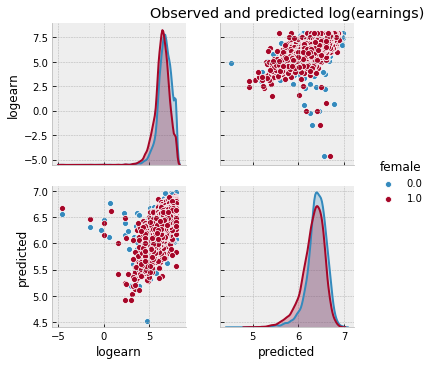

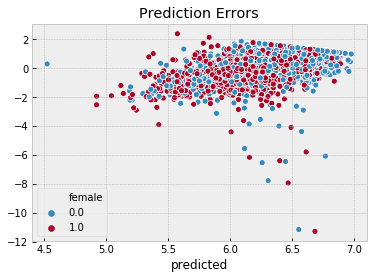

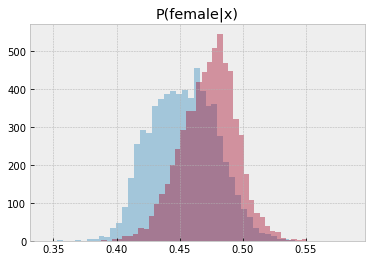

In [14]:
plotpredictions(pl_nn)

In [15]:
summary_col([pl_lasso[0], pl_nn[0]], model_names=["Lasso", "Neural Network"] ,stars=False)

,Lasso,Neural Network
x1,-0.1239,-0.2047
,(0.0114),(0.0127)


### Other applications

There are many other situations where machine learning can be used to
estimate nuisance functions. The partially linear model can easily be
extended to situations where the regressor of interest, $ d $ , is
endogenous and instruments are available. See [[CCD+18]](#chernozhukov2018)
for details and additional examples.

## Heterogeneous Effects

A third area where economists are using machine learning is to
estimate heterogeneous effects.

Some important papers in this area are [[AI16]](#athey2016b) ,
[[WA18]](#wager2018) , and [[CDDFV18]](#cddf2018) .

We will explore this is more depth in applications/heterogeneity

## References

<a id='alatas2011'></a>
\[ACE+11\] Vivi Alatas, Nur Cahyadi, Elisabeth Ekasari, Sarah Harmoun, Budi Hidayat, Edgar Janz, Jon Jellema, H Tuhiman, and M Wai-Poi. Program keluarga harapan : impact evaluation of indonesia’s pilot household conditional cash transfer program. Technical Report, World Bank, 2011. URL: [http://documents.worldbank.org/curated/en/589171468266179965/Program-Keluarga-Harapan-impact-evaluation-of-Indonesias-Pilot-Household-Conditional-Cash-Transfer-Program](http://documents.worldbank.org/curated/en/589171468266179965/Program-Keluarga-Harapan-impact-evaluation-of-Indonesias-Pilot-Household-Conditional-Cash-Transfer-Program).

<a id='athey2016b'></a>
\[AI16\] Susan Athey and Guido Imbens. Recursive partitioning for heterogeneous causal effects. *Proceedings of the National Academy of Sciences*, 113(27):7353–7360, 2016. URL: [http://www.pnas.org/content/113/27/7353](http://www.pnas.org/content/113/27/7353), [arXiv:http://www.pnas.org/content/113/27/7353.full.pdf](https://arxiv.org/abs/http://www.pnas.org/content/113/27/7353.full.pdf), [doi:10.1073/pnas.1510489113](https://doi.org/10.1073/pnas.1510489113).

<a id='chernozhukov2018'></a>
\[CCD+18\] Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, and James Robins. Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1):C1–C68, 2018. URL: [https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097), [arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097](https://arxiv.org/abs/https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097), [doi:10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

<a id='cddf2018'></a>
\[CDDFV18\] Victor Chernozhukov, Mert Demirer, Esther Duflo, and Iván Fernández-Val. Generic machine learning inference on heterogenous treatment effects in randomized experimentsxo. Working Paper 24678, National Bureau of Economic Research, June 2018. URL: [http://www.nber.org/papers/w24678](http://www.nber.org/papers/w24678), [doi:10.3386/w24678](https://doi.org/10.3386/w24678).

<a id='kleinberg2017'></a>
\[KMR17\] Jon Kleinberg, Himabindu Lakkaraju, Jure Leskovec, Jens Ludwig, and Sendhil Mullainathan. Human Decisions and Machine Predictions*. *The Quarterly Journal of Economics*, 133(1):237–293, 08 2017. URL: [https://dx.doi.org/10.1093/qje/qjx032](https://dx.doi.org/10.1093/qje/qjx032), [arXiv:http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf](https://arxiv.org/abs/http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf), [doi:10.1093/qje/qjx032](https://doi.org/10.1093/qje/qjx032).

<a id='kleinberg2015'></a>
\[KLMO15\] Jon Kleinberg, Jens Ludwig, Sendhil Mullainathan, and Ziad Obermeyer. Prediction policy problems. *American Economic Review*, 105(5):491–95, May 2015. URL: [http://www.aeaweb.org/articles?id=10.1257/aer.p20151023](http://www.aeaweb.org/articles?id=10.1257/aer.p20151023), [doi:10.1257/aer.p20151023](https://doi.org/10.1257/aer.p20151023).

<a id='triyana2016'></a>
\[Tri16\] Margaret Triyana. Do health care providers respond to demand-side incentives? evidence from indonesia. *American Economic Journal: Economic Policy*, 8(4):255–88, November 2016. URL: [http://www.aeaweb.org/articles?id=10.1257/pol.20140048](http://www.aeaweb.org/articles?id=10.1257/pol.20140048), [doi:10.1257/pol.20140048](https://doi.org/10.1257/pol.20140048).

<a id='wager2018'></a>
\[WA18\] Stefan Wager and Susan Athey. Estimation and inference of heterogeneous treatment effects using random forests. *Journal of the American Statistical Association*, 0(0):1–15, 2018. URL: [https://doi.org/10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839), [arXiv:https://doi.org/10.1080/01621459.2017.1319839](https://arxiv.org/abs/https://doi.org/10.1080/01621459.2017.1319839), [doi:10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839).